# **Biblioteki**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg

from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo
from factor_analyzer import FactorAnalyzer

# **Przygotowanie danych**

Inspiracja do zadania pochodzi ze sttony Kaggle: https://www.kaggle.com/code/ipravin/factor-analysis-and-linear-programming/notebook

**Jakie czynniki wpływają na satsysfakcję klienta ?**

Dane dotyczą ocen poszczególnych czynników wpływających na satysfakcję klienta z usługi - skala oceny w każdym przypadku była taka sama (1-10).

**Dane:**

ProdQual - jakość produktu,

Ecom - e-commerce (handel elektroniczny),

TechSup - pomoc techniczna,

CompRes - rozstrzygnięcia reklamacji,

Advertising	- reklama,

ProdLine - produkcja,
  
SalesFImage	- wizerunek sprzedawcy,
    
ComPricing	- konkurencyjność ceny,
    
WartyClaim - gwarancja i reklamacja,
    
OrdBilling - zamówienia i rachunki,
      
DelSpeed	- szybkość dostawy,
        
Satisfaction - satysfakcja.

In [2]:
df = pd.read_csv('Factor-Hair-Revised.csv')
df

,ID,ProdQual,Ecom,TechSup,CompRes,Advertising,ProdLine,SalesFImage,ComPricing,WartyClaim,OrdBilling,DelSpeed,Satisfaction
0,1,8.5,3.9,2.5,5.9,4.8,4.9,6.0,6.8,4.7,5.0,3.7,8.2
1,2,8.2,2.7,5.1,7.2,3.4,7.9,3.1,5.3,5.5,3.9,4.9,5.7
2,3,9.2,3.4,5.6,5.6,5.4,7.4,5.8,4.5,6.2,5.4,4.5,8.9
3,4,6.4,3.3,7.0,3.7,4.7,4.7,4.5,8.8,7.0,4.3,3.0,4.8
4,5,9.0,3.4,5.2,4.6,2.2,6.0,4.5,6.8,6.1,4.5,3.5,7.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,8.6,4.8,5.6,5.3,2.3,6.0,5.7,6.7,5.8,4.9,3.6,7.3
96,97,7.4,3.4,2.6,5.0,4.1,4.4,4.8,7.2,4.5,4.2,3.7,6.3
97,98,8.7,3.2,3.3,3.2,3.1,6.1,2.9,5.6,5.0,3.1,2.5,5.4
98,99,7.8,4.9,5.8,5.3,5.2,5.3,7.1,7.9,6.0,4.3,3.9,6.4


In [3]:
# usunięcie kolumny ID
df = df.drop(columns=['ID'])

array([[<Axes: title={'center': 'ProdQual'}>,
        <Axes: title={'center': 'Ecom'}>,
        <Axes: title={'center': 'TechSup'}>],
       [<Axes: title={'center': 'CompRes'}>,
        <Axes: title={'center': 'Advertising'}>,
        <Axes: title={'center': 'ProdLine'}>],
       [<Axes: title={'center': 'SalesFImage'}>,
        <Axes: title={'center': 'ComPricing'}>,
        <Axes: title={'center': 'WartyClaim'}>],
       [<Axes: title={'center': 'OrdBilling'}>,
        <Axes: title={'center': 'DelSpeed'}>,
        <Axes: title={'center': 'Satisfaction'}>]], dtype=object)

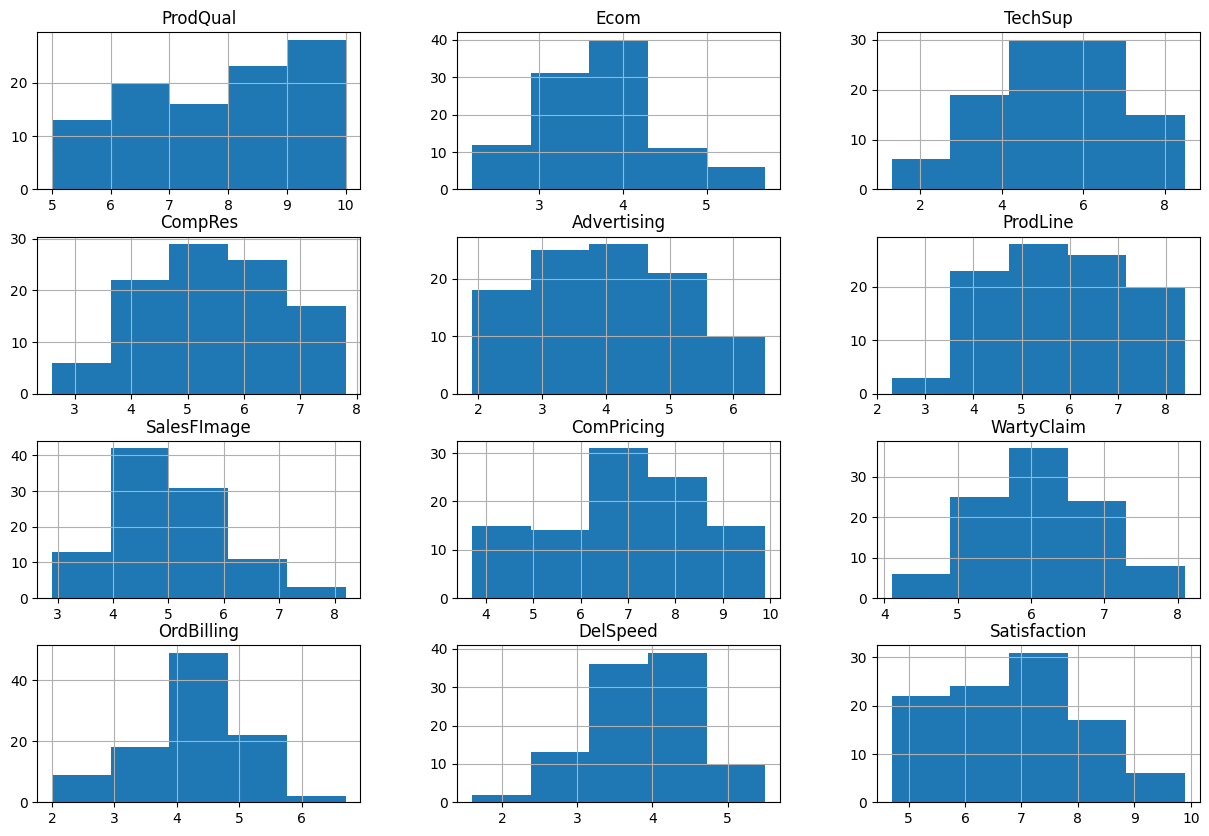

In [4]:
# Narysowanie rozkładów

df.hist(bins = 5,figsize=(15, 10))

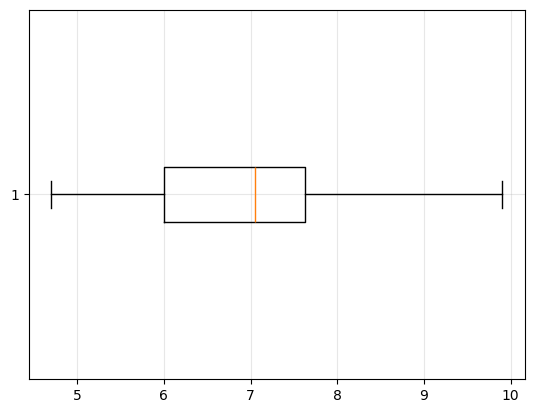

In [5]:
# wykres typu boxplot zmiennej objaśnianej
plt.boxplot(df['Satisfaction'], vert=False)
plt.grid(alpha=0.3)
plt.show()

In [6]:
# tabela przestawna
df1 = pd.melt(df, value_vars=['ProdQual',	'Ecom',	'TechSup','CompRes',	'Advertising',	'ProdLine',	'SalesFImage','ComPricing',	'WartyClaim',	'OrdBilling',	'DelSpeed',	'Satisfaction'])
df1 = df1.rename(columns={"variable": "group", "value": "score"})

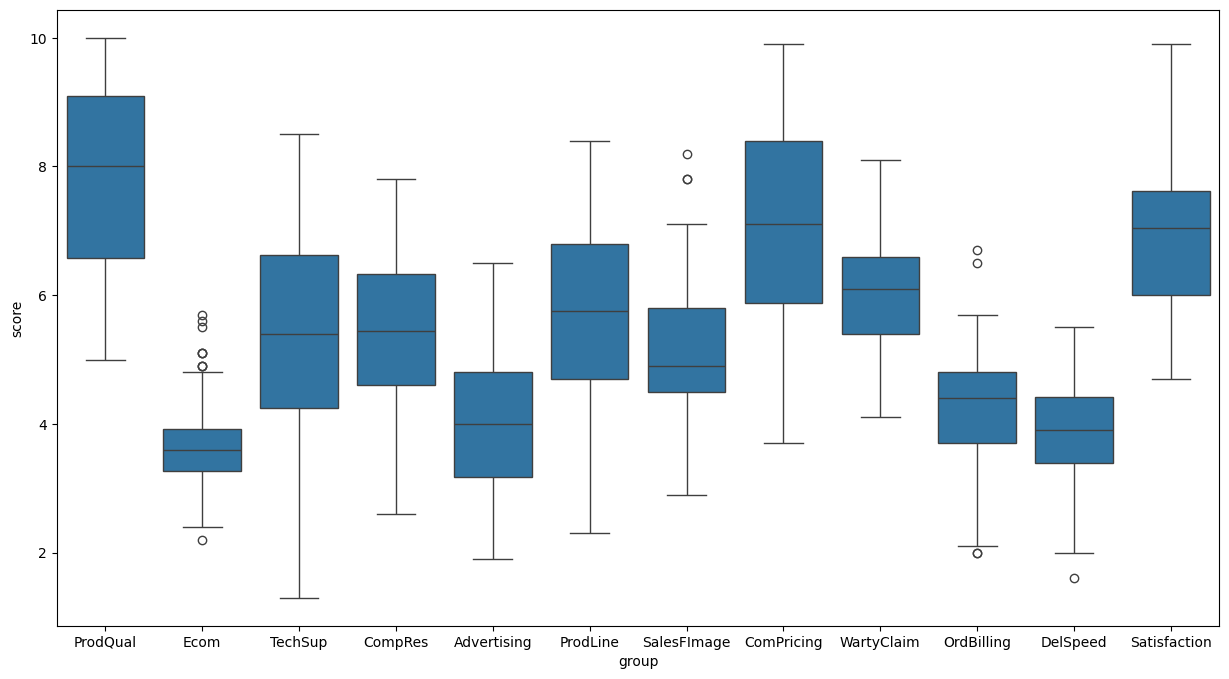

In [7]:
# narysowanie boxplotów

plt.figure(figsize=(15,8))
ax = sns.boxplot(x = 'group', y = 'score', data=df1)
plt.show()

**Proszę skomentować wykresy:**

1) czy na podstawie histogramów możemy przewidzieć, że rozkłady będą przypominać rozkład normalny ?

2) czy spodziewamy się, że grupy są do siebie podobne ?

**KOMENTARZ:** Niektre rozkłady (np Ecom) mają znaczne wartości odstające, więc raczej nie będą rozkładami normalnymi. Natomiast rozkłady TechSup, CompRes, ProdLine mają dość podobną medianę, podobną ilość "pudełka" na górze i na dole (kwantyle podobnie oddalone od mediany) i także w miarę równe "kreski" (kwantyle minimum/ maximum), więc można się spodziewać że będą to rozkłady normalne podobne do siebie

# **Analiza czynnikowa**

**Analiza czynnikowa** jest to metoda statystyczna wykorzystywana do redukcji zbiorów danych do najmniejszej możliwej liczby czynników przy pomocy badania współzależności między zmiennymi. Skorelowane zmienne wyjaśniające łączone są w grupy, które są spójne wewnętrznie i różne międzygrupowo. Grupa zmiennych wyjaśniającyh nazywana jest czynnikiem lub faktorem - są to tzw. zmienne ukryte (duża liczba zmiennych obserwowanych reprezentuje mniejszą liczbę zmiennych ukrytych).  

W analizie czynnikowej grupy nie powinny mieć takich samych wariancji (brak jednorodność wariancji), ponieważ jeżeli grupy będą zbyt podobne to rozróżnienie czynników będzie zdecydowanie trudniejsze.
Zmienne powinny ze sobą istotnie korelować. Należy jednak pamiętać, że zmienne powinny być niezależne w tym sensie, że nie może to być jedna jednostka statystyczna poddana wpływowi np. ciśnienie mierzone przed zażyciem lekarstwa i po zażyciu lekarstwa. Dodatkowo zmienne powinny mieć rozkład normalny.

**UWAGA:** Wszystkie zmienne muszą być mierzone w tej samej skali, jeżeli skala jest różna to należy wykonać standaryzację zmiennych.


**Biblioteka:** https://pypi.org/project/factor-analyzer/

**1. Normalność rozkładów**

Na poziomie istotności alfa = 0.01 proszę zbadać normalność rozkładów.

pg.normality(dane, group = 'group', dv = 'score', alpha = alfa)

**H0:** rozkład jest normalny

**H1:** rozkład nie jest normalny

In [8]:
# Rozwiązanie
pg.normality(df1, group = 'group', dv = 'score', alpha = 0.01)

,W,pval,normal
group,,,
ProdQual,0.949722,0.000795,False
Ecom,0.958517,0.003157,False
TechSup,0.986264,0.390045,True
CompRes,0.986459,0.402254,True
Advertising,0.976257,0.067691,True
ProdLine,0.986923,0.432454,True
SalesFImage,0.974033,0.045342,True
ComPricing,0.967584,0.014485,True
WartyClaim,0.990942,0.740365,True


**ODP:**

In [9]:
# usunięcie zmiennych, które nie mają rozkładu normalnego

df = df.drop(columns=['ProdQual', 'Ecom'])

**2. Test jednorodności wariancji**

Proszę sprawdzić czy wariancje są jednorodne.

**H0:** Wariancje we wszystkich grupach są sobie równe.

**H1:** Wariancje dla conajmniej jednej pary wykonanych serii prób są różne: sigma_i =/= sigma_j

Wykonujemy test homoscedasticity, który wymaga normalności rozkładów. Rozkłady są normalne ponieważ sprawdziliśmy to pole wyżej

In [10]:
# Rozwiązanie
pg.homoscedasticity(df1, group='group', dv='score', method = 'bartlett')

,T,pval,equal_var
bartlett,146.522042,7.644413e-26,False


**ODP:** P val jest bliskie zeru, hipotezę zerową można odrzucić. Wariancje dla conajmniej jednej pary są różne

 Wszystkie zmienne mają rozkład normalny, a wariancje dla conajmniej jednej pary wykonanych serii prób są różne.

 W statystyce istnieją dwa testy: test sferyczności Barletta oraz test K-M-O (Kaiser-Meyer-Olkin), które pozwalaja określić czy możliwe jest wykonanie analizy czynnikowej.  


**3. Test sferyczności Barletta**

Test sferyczności Barletta testuje założenie o braku korelacji między zmiennymi. Celem stosowania testu Bartletta jest ocena założenia o sferyczności macierzy korelacji między zmiennymi. Jeżeli nie ma podstaw do odrzucenia H0 (wynik jest nieistotny statystycznie) to znaczy, że nie należy wykonywać analizy czynnikowej, ponieważ każda zmienna jest doskonale ortogonalna (nieskorelowana z każdą inną zmienną). Jeżeli wynik testu jest istotny statystycznie to oznacza, że zmienne sa skorelowane - czyli można wykonać analizę czynnikową.

**Hipotezy:**


**H0:** Zmienne są ortogonalne (brak korelacji między zmiennymi).

**H1:** Zmienne nie są ortogonalne (istnieje korealacja między zmiennymi)


In [11]:
calculate_bartlett_sphericity(df)

(579.9047825737875, 4.694003477436801e-94)

**ODP:** Zgodnie z dokumentacją funkcji druga zwracana wartość to pvalue. Jest ona bliska zeru, więc H0 można odrzucić. H1, mówiące o tym że zmienne NIE są ortogonalne, świadczy o tym że zmienne SĄ skorelowane. Dlatego można wykonać analizę czynnikową.

**4. Test KMO**


Test KMO jest przeprowadzany w celu określenie czy zbiór danych jest adekwatny do przeprowadzanie analizy czynnikowej. Bada on siły częściowej korelacji, czyli w jaki sposób czynniki wyjaśniają się nawzajem. Współczynnik KMO przyjmuje wartości od 0 do 1. Im wartość współczynnika KMO bliższa jest 1 tym wykonanie analizy czynnikowej jest bardziej zasadne. Przyjmuje się, że wartość KMO mniejsza niż 0,5 (w zależności od źródła  czasami jest to 0,6) jest niedopuszczalna i oznacza, że dane nie są odpowiednie do wykonania analizy czynnikowej.

In [12]:
kmo_all, kmo_model = calculate_kmo(df)
print(kmo_model)

0.6875065817911215


**ODP:** Wartość KMO wynosi 0.68, czyli spełnia kryterium 0.5. Oznacza to że zmienne są częściowo skorelowane, wyjaśniają się w pewnien sposób - wykonanie analizy czynnikowej jest dozwolone. 

**Na podstawie testów proszę określić czy można przeprowadzić analizę czynnikową?**

**KOMENTARZ:** Można określić, ale nie jednoznacznie. Prawie wszystkie testy pozwalają nam jedynie odrzucić hipotezę zerową. Jeżeli gdziekolwiek p wyszłoby za duże, jedynie możnaby powiedzieć że żadnej z hipotez nie można potwierdzić bądź zaprzeczyć. Wtedy nadal można próbować robić analizę, jedynie nie wiadomo czy da ona sensowne wyniki.

**OKREŚLENIE LICZBY CZYNNIKÓW (FAKTORÓW)**

Do okreslenia liczby czynników można wykorzystać jedno z dwóch kryteriów:

1) kryterium Cattella oparte na wykresie osuwiska - by określić liczbę faktorów na wykresie poszukuje się takiego miejsca, w którym przestaje być on stromy (przestaje się osypywać), następnie zlicza się liczbę punktów powyżej tego miejsca (liczba punktów = liczbie faktorów),

2) kryterium Kaisera liczba czynników jest równa liczbie składowych z wartością własną większą od jedynki (przy duże ilości składowych kryterium to może wyodrębnić zbyt dużą liczbę faktorów).


In [13]:
fa = FactorAnalyzer()

fa.fit(df)

ev, v = fa.get_eigenvalues()
ev                            # wartości własne

array([3.87044814, 2.04479787, 1.50994101, 0.86013254, 0.55916701,
       0.40681921, 0.25939254, 0.23897652, 0.14569514, 0.10463001])

In [14]:
values = np.arange(1, len(ev)+1)

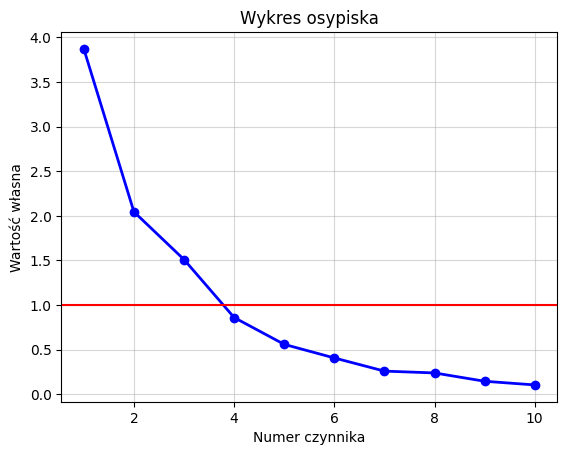

In [15]:
plt.plot(values, ev, 'o-', linewidth=2, color='blue')
plt.axhline(y = 1, color = 'r', label = 'axvline - full height')

plt.title('Wykres osypiska')
plt.xlabel('Numer czynnika')
plt.ylabel('Wartość własna')
plt.grid(alpha = 0.5)
plt.show()

**Na podstawie wykresu osypiska i kryterium Kasiera proszę określić ile czynników można wyróżnić?**

**KOMENTARZ:**

Oprócz wyznaczenia liczby faktorów, analiza czynnikowa umożliwia dokonanie rotacji (obrócenia osi). Rotacja ma na celu ułatwienie interpretacji czynników i ograniczenie liczby niewyjaśnionych zmiennych (zdarza się, że niektóre zmienne nie są przypisywane do żadnego czynnika).

**Metody rotacji:**

varimax (rotacja ortogonalna)

promax (rotacja ukośna)

oblimin (ukośny obrót)

oblimax (rotacja ortogonalna)

kwartimin (rotacja ukośna)

quartimax (rotacja ortogonalna)

equamax (rotacja ortogonalna)

geomin_obl (obrót ukośny)

geomin_ort (obrót ortogonalny)

Najpopularniejsze typy rotacji to:

- rotacja varimax - minimalizuje liczbę zmiennych niezbędnych do wyjaśnienia danego zjawiska,

- rotacja promax - nieortagonalna metoda rotacji, dopuszczająca skorelowanie czynników, zazwyczaj stosowana do dużych zbiorów.

**Wyniki interpretuje się na podstawie ładunków czynnikowych:**

**Ładunki czynnikowe** to standaryzowane współczynniki regresji zmiennych obserwowanych względem czynników. Zmienne, które posiadają wystarczającą wartość bezwzględną ładunków czynnikowych są przypisywane do danego faktora. Wartość graniczna jest ustalana dla danego przypadku. Najlepiej byłoby gdyby wartość ładunku danaj zmiennej jednoznacznie klasyfikowałaby ją do danego faktora - w praktyce nie zawsze jest to możliwe.

In [16]:
fa = FactorAnalyzer(3, rotation='varimax')
fa.fit(df)
print(fa.loadings_)

[[ 0.03247989  0.87141169 -0.04528087]
 [ 0.89156061  0.03659735  0.11924429]
 [ 0.18126828 -0.0358086   0.539549  ]
 [ 0.71233381  0.24086161 -0.24289387]
 [ 0.15794221  0.07862691  0.94596671]
 [-0.2563462  -0.30158724  0.36725722]
 [ 0.11649091  0.88484268  0.03459996]
 [ 0.75241133  0.06556319  0.1234986 ]
 [ 0.90653762 -0.02293137  0.16963662]
 [ 0.66572994  0.15283273  0.31686058]]


**Utworzenie tabeli ułatwiającej interpretację.**

In [17]:
lmatrix = pd.DataFrame(fa.loadings_, index = list(df.columns), columns = ['Factor 1', 'Factor 2', 'Factor 3'])

# obliczenie wartości bezwzględnych

lmatrix = lmatrix.abs()
lmatrix

,Factor 1,Factor 2,Factor 3
TechSup,0.032480,0.871412,0.045281
CompRes,0.891561,0.036597,0.119244
Advertising,0.181268,0.035809,0.539549
ProdLine,0.712334,0.240862,0.242894
SalesFImage,0.157942,0.078627,0.945967
ComPricing,0.256346,0.301587,0.367257
WartyClaim,0.116491,0.884843,0.034600
OrdBilling,0.752411,0.065563,0.123499
DelSpeed,0.906538,0.022931,0.169637
Satisfaction,0.665730,0.152833,0.316861


In [18]:
lmatrix.sort_values('Factor 1', ascending=False)

,Factor 1,Factor 2,Factor 3
DelSpeed,0.906538,0.022931,0.169637
CompRes,0.891561,0.036597,0.119244
OrdBilling,0.752411,0.065563,0.123499
ProdLine,0.712334,0.240862,0.242894
Satisfaction,0.665730,0.152833,0.316861
ComPricing,0.256346,0.301587,0.367257
Advertising,0.181268,0.035809,0.539549
SalesFImage,0.157942,0.078627,0.945967
WartyClaim,0.116491,0.884843,0.034600
TechSup,0.032480,0.871412,0.045281


**Proszę posortować wartości według pozostałych czynników:**

In [19]:
# Rozwiązanie
lmatrix.sort_values('Factor 2', ascending=False)

,Factor 1,Factor 2,Factor 3
WartyClaim,0.116491,0.884843,0.034600
TechSup,0.032480,0.871412,0.045281
ComPricing,0.256346,0.301587,0.367257
ProdLine,0.712334,0.240862,0.242894
Satisfaction,0.665730,0.152833,0.316861
SalesFImage,0.157942,0.078627,0.945967
OrdBilling,0.752411,0.065563,0.123499
CompRes,0.891561,0.036597,0.119244
Advertising,0.181268,0.035809,0.539549
DelSpeed,0.906538,0.022931,0.169637


In [20]:
lmatrix.sort_values('Factor 3', ascending=False)

,Factor 1,Factor 2,Factor 3
SalesFImage,0.157942,0.078627,0.945967
Advertising,0.181268,0.035809,0.539549
ComPricing,0.256346,0.301587,0.367257
Satisfaction,0.665730,0.152833,0.316861
ProdLine,0.712334,0.240862,0.242894
DelSpeed,0.906538,0.022931,0.169637
OrdBilling,0.752411,0.065563,0.123499
CompRes,0.891561,0.036597,0.119244
TechSup,0.032480,0.871412,0.045281
WartyClaim,0.116491,0.884843,0.034600


**Proszę pogrupować zmienne na faktory zgodnie z najwyższą wartością ładunku czynnikowego:**

**wartość graniczna:** 0,50 (zmienne z wartością ładunku poniżej tej wartości nie zostają przypisane do żadnego czynnika)

**UWAGA:** w grupowaniu nie bierzemy pod uwagę Satysfakcji, ponieważ jest to zmienna objaśniana.

**KOMENTARZ:**

Faktor 1: ProdLine, DelSpeed, OrdBilling, CompRes

Faktor 2: WartyClaim, TechSup

Faktor 3: SalesFImage, Advertising




### **Zadanie:**
Proszę przeprowadzić analizy:

1) dla 3 czynników, rotacja: 'promax'

2) dla 4 czynników, rotacja: 'varimax'

**wartość graniczna:** 0,50 (zmienne z wartością ładunku poniżej tej wartości nie zostają przypisane do żadnego czynnika)

Na podstawie wyników proszę zdecydować na ile faktorów należy pogrupować zmienne oraz jaką metodę rotacji należy wybrać dla analizowanego zbioru danych.

In [21]:
# Rozwiązanie z 1
fa = FactorAnalyzer(3, rotation='promax')
fa.fit(df)
print(fa.loadings_)
lmatrix = pd.DataFrame(fa.loadings_, index = list(df.columns), columns = ['Factor 1', 'Factor 2', 'Factor 3'])

[[-0.14326922  0.92546943  0.06680702]
 [ 0.92178375 -0.10732919  0.05745542]
 [ 0.15216201  0.01389804  0.53867052]
 [ 0.72147247  0.088203   -0.27549551]
 [ 0.0688549   0.20643156  0.97596107]
 [-0.23893334 -0.21855477  0.35981002]
 [-0.0643833   0.9370744   0.14452133]
 [ 0.76873541 -0.04956844  0.07675177]
 [ 0.94563208 -0.16619342  0.10042877]
 [ 0.64260798  0.09145021  0.29517341]]
